In [0]:
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.datasets import cifar10
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

In [0]:
# CIFAR-10 の画像をロードする
# 普通はネットからダウンロードしてきてそれを読み込むのだが、
# KerasではCIFAR10をダウンロードしてきて読み込むところまでを
# やってくれる機能があるのでそれを使っている
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# CIFAR-10の教師データは 0 〜 9 までの数字になっているが、これだと人はわかりにくいので
# 0 → airplane, 1 → automobile…のような対応関係を配列で持っておく
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


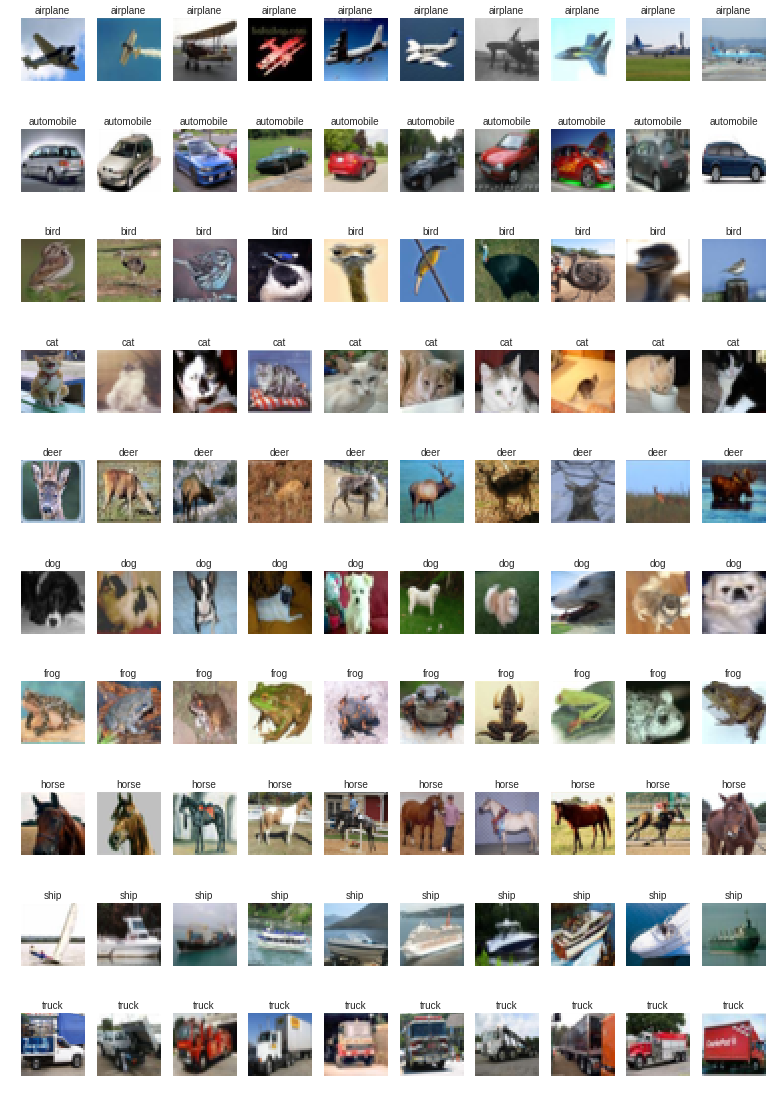

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

nclasses = 10
pos = 1
plt.figure(figsize=(16,24), dpi=60)

# matplotlib で学習用画像を10個ずつ表示する
# matplotlib はグラフを表示するためのライブラリでものすごく多機能なため、
# 便利ではあるがかなりとっつきづらい
# 細かい説明はキリがないので興味があれば調べてみてほしい。
for targetClass in range(nclasses):
    targetIdx = []
    for i in range(len(y_train)):
        if y_train[i][0] == targetClass:
            targetIdx.append(i)

    np.random.shuffle(targetIdx)
    for idx in targetIdx[:10]:
        # X_train[idx] は3次元の行列になっており、そのままだと数字の羅列が表示されるだけなので
        # toimage を使って画像に変換してから表示する
        img = toimage(X_train[idx])
        plt.subplot(10, 10, pos)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cifar10_labels[y_train[idx][0]])
        pos += 1

plt.show()

In [0]:
# floatに変換しておく
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0

# one-hot vector に変換したほうが都合が良い
# たとえば 4 ではなくて [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] のようなデータにする
# こうしないとクラス分類ではなくて回帰として扱われてしまいうまくいかない
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [58]:
#
# ResNet のモデルを定義するセル
#

# inputs と residual 2つの処理結果を受け取って、両者を足す
def _shortcut(inputs, residual):
  
  # residual のほうのフィルタ数を取得する
  # ちなみに
  # _keras_shape[1] 画像の幅
  # _keras_shape[2] 画像の高さ
  # _keras_shape[3] チャンネル数
  # になっている(デフォルトでは)。
  # 本当はチャンネル数、幅、高さの順番のこともあるので
  # それを考慮したコードにしなければならないのだが、今回はこれで問題ない
  n_filters = residual._keras_shape[3]
  
  # inputs と residual とでチャネル数が違うかもしれない。
  # そのままだと足せないので、1x1 conv を使って residual 側のフィルタ数に合わせている
  shortcut = Convolution2D(n_filters, (1,1), strides=(1,1), padding='valid')(inputs)
  
  # 2つを足す
  return add([shortcut, residual])


# ResBlock を定義
# ここでの処理は BatchNorm → ReLU → Conv とシンプルなものにしてあるが、
# ここを色々変更する改良案が無数にある
def _resblock(n_filters, strides=(1,1)):
  def f(input):    
    x = Convolution2D(n_filters, (3,3), strides=strides,
                                      kernel_initializer='he_normal', padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(n_filters, (3,3), strides=strides,
                                      kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    
    # 入力そのものと、BN→ReLU→Conv したものとを足す
    # この部分がResNetのもっとも重要な点
    return _shortcut(input, x)
    
  return f


def resnet():
  # 入力テンソルを定義しておく
  inputs = Input(shape=(32, 32, 3))
  
  # ResBlock で処理をする前に、いったん
  # 7x7で畳み込み→BN→ReLU　をし、さらに MaxPooling している
  # これは無くても動くが、早い段階でとりあえずMaxPoolingすることで画像サイズが1/2になるので
  # パラメータ数の増加を抑える(高速に学習できる)効果がある
  
  # 7x7conv→BN→ReLU
  x = Convolution2D(32, (7,7), strides=(1,1),
                    kernel_initializer='he_normal', padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  # MaxPoolingで縮小
  x = MaxPooling2D((3, 3), strides=(2,2), padding='same')(x)
  
  #ここからは ResBlock を積み重ねていく
  # 下では ResBlock x3 → MaxPooling → ResBlock x3 という非常に小さいネットワーク
  
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = _resblock(n_filters=64)(x)
  x = MaxPooling2D(strides=(2,2))(x)  
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)
  x = _resblock(n_filters=128)(x)

  # Global Average Pooling したあとに Fully Connection Network ( = Dense) する
  x = GlobalAveragePooling2D()(x)
  x = Dense(10, kernel_initializer='he_normal', activation='softmax')(x)
  
  # Keras では、入力と出力の2個だけを指定すると、計算に必要なネットワークを勝手に構築してくれる機能がある
  # inputs は初めに定義しておいた  Input(shape=(32, 32, 3)) で、
  # outputs は softmax で10個の出力を行う Dense のネットワークなので、その2つを指定する
  model = Model(inputs=inputs, outputs=x)
  return model

model = resnet()

# optimizer として Adam を指定する。SGDでも良いがAdamのほうが収束が早い
adam = Adam()

# inputs から outputs を求める計算をするようにコンパイルする
# ここでネットワークでどのような処理を行うかが全て決定される
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 今作ったネットワークがどんなネットワークなのか概要を表示する機能(見られるだけなので無くても良い)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 32, 32, 32)   4736        input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 32, 32, 32)   128         conv2d_220[0][0]                 
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 32, 32, 32)   0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
max_poolin

In [59]:
# 1 epoch ごとに　weights.01.hdf5, weights.02.hdf5 … のようにモデルを保存してくれる
callback_cp = ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5')

# 1 epoch ごとに val_acc　に変化があるか調べて、殆ど変わってなかったら学習を打ち切る
callback_es = EarlyStopping(monitor='val_acc', patience=2, mode='auto', verbose=1)

batch_size = 50
epochs = 10

# 学習する
h = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2,
              callbacks=[callback_cp, callback_es])

# 学習が終わった最終状態を保存する
model.save('model.hdf5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
33550/40000 [========================>.....] - ETA: 10s - loss: 1.7265 - acc: 0.4107

40000/40000 [==============================] - 64s 2ms/step - loss: 1.6806 - acc: 0.4218 - val_loss: 2.4760 - val_acc: 0.3235
Epoch 2/10
19500/40000 [=============>................] - ETA: 28s - loss: 1.3718 - acc: 0.5115

40000/40000 [==============================] - 58s 1ms/step - loss: 1.3450 - acc: 0.5205 - val_loss: 1.9547 - val_acc: 0.3842
Epoch 3/10
14600/40000 [=========>....................] - ETA: 29s - loss: 1.2431 - acc: 0.5579

40000/40000 [==============================] - 53s 1ms/step - loss: 1.2303 - acc: 0.5654 - val_loss: 3.1443 - val_acc: 0.2387
Epoch 4/10
14250/40000 [=========>....................] - ETA: 27s - loss: 1.1617 - acc: 0.5896

40000/40000 [==============================] - 48s 1ms/step - loss: 1.1555 - acc: 0.5918 - val_loss: 1.5639 - val_acc: 0.4621
Epoch 5/10
15000/40000 [==========>...................] - ETA: 26s - loss: 1.1067 - acc: 0.6093

40000/40000 [==============================] - 45s 1ms/step - loss: 1.0991 - acc: 0.6127 - val_loss: 1.2922 - val_acc: 0.5472
Epoch 6/10
15950/40000 [==========>...................] - ETA: 25s - loss: 1.0661 - acc: 0.6258

40000/40000 [==============================] - 46s 1ms/step - loss: 1.0558 - acc: 0.6296 - val_loss: 1.3466 - val_acc: 0.5428
Epoch 7/10
15700/40000 [==========>...................] - ETA: 25s - loss: 1.0045 - acc: 0.6474

40000/40000 [==============================] - 46s 1ms/step - loss: 1.0099 - acc: 0.6475 - val_loss: 1.2783 - val_acc: 0.5709
Epoch 8/10
14950/40000 [==========>...................] - ETA: 27s - loss: 0.9680 - acc: 0.6597

40000/40000 [==============================] - 46s 1ms/step - loss: 0.9728 - acc: 0.6587 - val_loss: 1.2351 - val_acc: 0.6082
Epoch 9/10
15100/40000 [==========>...................] - ETA: 26s - loss: 0.9440 - acc: 0.6738

40000/40000 [==============================] - 45s 1ms/step - loss: 0.9432 - acc: 0.6727 - val_loss: 1.1689 - val_acc: 0.5926
Epoch 10/10
14400/40000 [=========>....................] - ETA: 29s - loss: 0.8953 - acc: 0.6884

40000/40000 [==============================] - 53s 1ms/step - loss: 0.9077 - acc: 0.6830 - val_loss: 1.1823 - val_acc: 0.6011
Epoch 00010: early stopping


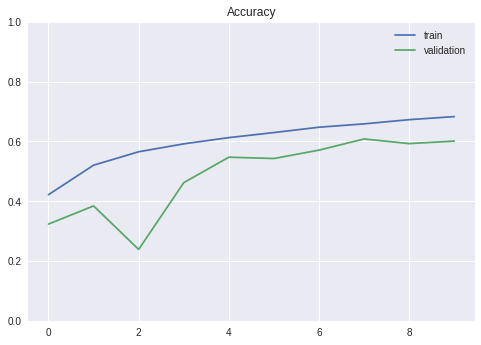

In [62]:
import numpy as np
import matplotlib.pyplot as plt

epoch = np.arange(len(h.history['acc']))

# accuracy と validation accuracy の推移をプロットする
plt.title('Accuracy')
plt.ylim(0.0, 1.0)
plt.plot(epoch, h.history['acc'], label='train')
plt.plot(epoch, h.history['val_acc'], label='validation')
plt.legend()
plt.show()

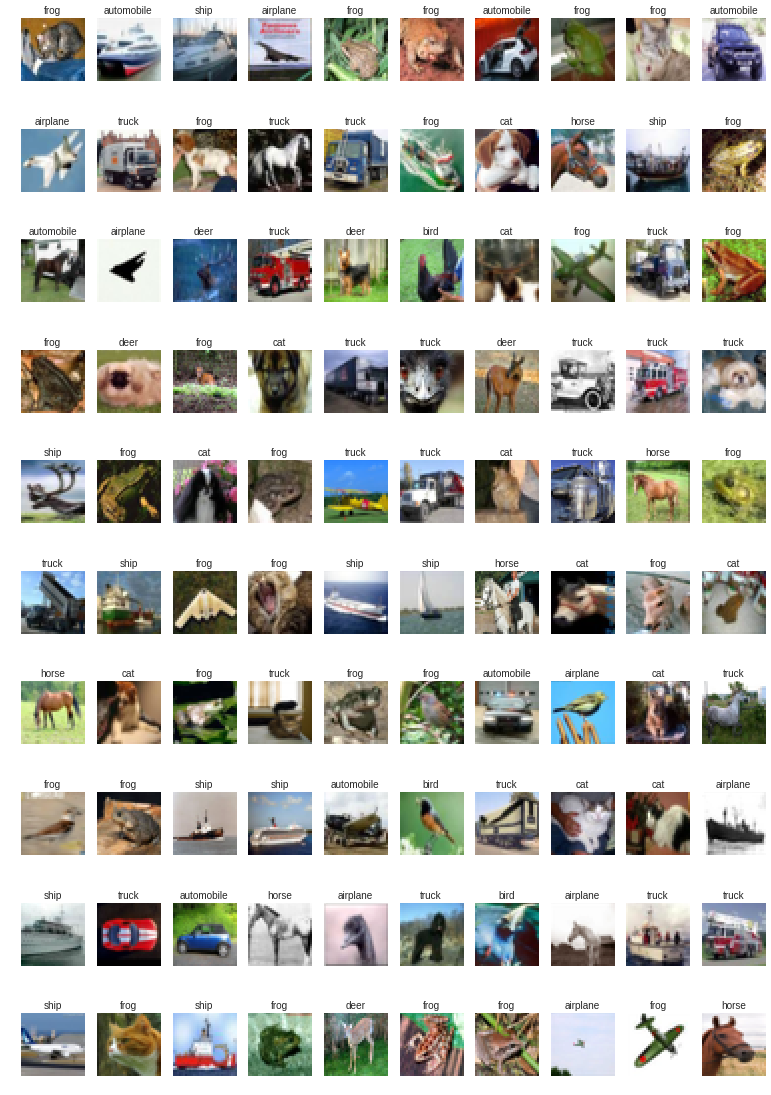

In [61]:
results = model.predict(X_test)

pos = 1
plt.figure(figsize=(16,24), dpi=60)

for i in range(100):
  img = toimage(X_test[i])
  label = results[i].argmax()
  plt.subplot(10, 10, pos)
  plt.imshow(img)
  plt.axis('off')
  plt.title(cifar10_labels[label])
  pos += 1        

plt.show()